In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# LSTM Model applied on 2nd Dataset

In [2]:
data = pd.read_csv(r'C:\Users\hp\Downloads\APDS\Econometrics with R\RX_CACA5_Merged.csv')
data.head()

,time,voltage-I,voltage-II,voltage-III,current-I,current-II,current-III,wattage-I,wattage-II,wattage-III,...,drivingEndBearingTemp-II,nonDrivingEndBearingTemp-I,nonDrivingEndBearingTemp-II,deHorizontalVib,deVerticalVib,deAxialVib,nde_horizontalVib,nde_verticalVib,nde_axialVib,profile_id
0,10:47:56,11440,11470,11460,42.0,42.0,40,17000,4000,13000,...,36.2,35.7,34.1,1.3,1.0,0.7,1.0,1.0,1.1,5
1,10:48:57,10660,10700,10670,37.0,36.0,35,15000,3000,11000,...,36.9,36.2,34.6,1.3,1.0,0.8,1.0,1.0,1.1,5
2,10:49:58,10670,10710,10680,37.0,36.0,35,15000,3000,10000,...,37.5,36.6,35.0,1.3,1.1,0.9,1.1,1.2,1.1,5
3,10:50:58,10650,10700,10660,37.0,36.0,35,14000,3000,11000,...,38.2,37.0,35.4,1.3,1.0,0.9,1.1,1.1,1.0,5
4,10:51:58,10705,10755,10715,37.5,36.5,35,14500,3000,11000,...,38.8,37.3,35.7,1.3,1.1,1.0,1.2,1.2,1.2,5


In [3]:
lstm_data = data.copy()

In [4]:
#lstm_data
    
# Drop profile_id column
lstm_data = lstm_data.drop('profile_id', axis=1)

In [5]:
# Split df into X and y
data = lstm_data[['time', 'nonDrivingEndBearingTemp-I', 'nonDrivingEndBearingTemp-II']]
data

,time,nonDrivingEndBearingTemp-I,nonDrivingEndBearingTemp-II
0,10:47:56,35.7,34.1
1,10:48:57,36.2,34.6
2,10:49:58,36.6,35.0
3,10:50:58,37.0,35.4
4,10:51:58,37.3,35.7
...,...,...,...
176,13:46:07,59.7,58.3
177,13:47:08,59.7,58.1
178,13:48:09,59.5,57.9
179,13:49:09,59.3,57.7


In [6]:
#df['temp'] = data[['drivingEndBearingTemp-I', 'drivingEndBearingTemp-II','nonDrivingEndBearingTemp-I', 'nonDrivingEndBearingTemp-II'].mean(axis=1)

data['temp'] = data['nonDrivingEndBearingTemp-I'] + data['nonDrivingEndBearingTemp-II'] 
#data['temp'] = d['temp']/4
data['temp'] = data['temp'].div(2).round(2)

data = data.drop(['nonDrivingEndBearingTemp-I', 'nonDrivingEndBearingTemp-II'], axis=1)
#data = data.drop('time', axis=1)
data.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_5692\908091440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['temp'] = data['nonDrivingEndBearingTemp-I'] + data['nonDrivingEndBearingTemp-II']
C:\Users\hp\AppData\Local\Temp\ipykernel_5692\908091440.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['temp'] = data['temp'].div(2).round(2)


,time,temp
0,10:47:56,34.9
1,10:48:57,35.4
2,10:49:58,35.8
3,10:50:58,36.2
4,10:51:58,36.5


In [7]:
data.index = pd.to_datetime(data["time"], format='%H:%M:%S')
data = data.drop('time', axis=1)

In [8]:
data.shape

(181, 1)

In [9]:
data.head()

,temp
time,
1900-01-01 10:47:56,34.9
1900-01-01 10:48:57,35.4
1900-01-01 10:49:58,35.8
1900-01-01 10:50:58,36.2
1900-01-01 10:51:58,36.5


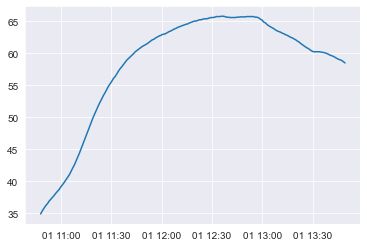

In [10]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['temp'])

In [11]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [12]:
time_step = 5
a,b = df_to_X_y(data, time_step)
X2 = a.reshape(176,5,1)
y2 = b.reshape(176)
X2.shape, y2.shape

((176, 5, 1), (176,))

In [13]:
X2

array([[[34.9 ],
        [35.4 ],
        [35.8 ],
        [36.2 ],
        [36.5 ]],

       [[35.4 ],
        [35.8 ],
        [36.2 ],
        [36.5 ],
        [36.9 ]],

       [[35.8 ],
        [36.2 ],
        [36.5 ],
        [36.9 ],
        [37.2 ]],

       [[36.2 ],
        [36.5 ],
        [36.9 ],
        [37.2 ],
        [37.5 ]],

       [[36.5 ],
        [36.9 ],
        [37.2 ],
        [37.5 ],
        [37.8 ]],

       [[36.9 ],
        [37.2 ],
        [37.5 ],
        [37.8 ],
        [38.15]],

       [[37.2 ],
        [37.5 ],
        [37.8 ],
        [38.15],
        [38.45]],

       [[37.5 ],
        [37.8 ],
        [38.15],
        [38.45],
        [38.75]],

       [[37.8 ],
        [38.15],
        [38.45],
        [38.75],
        [39.15]],

       [[38.15],
        [38.45],
        [38.75],
        [39.15],
        [39.5 ]],

       [[38.45],
        [38.75],
        [39.15],
        [39.5 ],
        [39.85]],

       [[38.75],
        [39.15],
        [

In [14]:
y2

array([36.9 , 37.2 , 37.5 , 37.8 , 38.15, 38.45, 38.75, 39.15, 39.5 ,
       39.85, 40.25, 40.65, 41.05, 41.55, 42.1 , 42.6 , 43.2 , 43.8 ,
       44.45, 45.15, 45.85, 46.55, 47.2 , 47.95, 48.6 , 49.3 , 49.95,
       50.55, 51.2 , 51.75, 52.3 , 52.8 , 53.35, 53.8 , 54.3 , 54.8 ,
       55.2 , 55.6 , 56.05, 56.35, 56.75, 57.2 , 57.6 , 57.9 , 58.25,
       58.6 , 58.95, 59.2 , 59.45, 59.7 , 59.95, 60.25, 60.45, 60.65,
       60.85, 61.05, 61.2 , 61.35, 61.5 , 61.7 , 61.9 , 62.1 , 62.2 ,
       62.4 , 62.55, 62.7 , 62.8 , 62.95, 63.  , 63.1 , 63.25, 63.4 ,
       63.5 , 63.65, 63.8 , 63.9 , 64.05, 64.15, 64.25, 64.35, 64.45,
       64.55, 64.6 , 64.75, 64.85, 64.95, 65.05, 65.05, 65.15, 65.25,
       65.25, 65.35, 65.4 , 65.4 , 65.45, 65.55, 65.6 , 65.6 , 65.65,
       65.75, 65.75, 65.75, 65.8 , 65.8 , 65.75, 65.65, 65.65, 65.6 ,
       65.6 , 65.6 , 65.6 , 65.65, 65.65, 65.7 , 65.7 , 65.7 , 65.7 ,
       65.75, 65.75, 65.75, 65.75, 65.75, 65.65, 65.65, 65.55, 65.35,
       65.2 , 64.9 ,

In [15]:
X_train2, y_train2 = X2[:100], y2[:100]
X_val2, y_val2 = X2[100:120], y2[100:120]
X_test2, y_test2 = X2[120:], y2[120:]
#X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp1 = ModelCheckpoint('model1', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.03), metrics=[RootMeanSquaredError()])

In [20]:
model1.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=35, callbacks=[cp1])

Epoch 1/35
1/4 [======>.......................] - ETA: 14s - loss: 58.8585 - root_mean_squared_error: 7.6719

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 19s 5s/step - loss: 73.7915 - root_mean_squared_error: 8.5902 - val_loss: 91.4156 - val_root_mean_squared_error: 9.5612
Epoch 2/35
1/4 [======>.......................] - ETA: 0s - loss: 62.0342 - root_mean_squared_error: 7.8762

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 13s 4s/step - loss: 59.2023 - root_mean_squared_error: 7.6943 - val_loss: 21.6435 - val_root_mean_squared_error: 4.6523
Epoch 3/35
1/4 [======>.......................] - ETA: 0s - loss: 44.0468 - root_mean_squared_error: 6.6368

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 16s 5s/step - loss: 59.8336 - root_mean_squared_error: 7.7352 - val_loss: 10.6657 - val_root_mean_squared_error: 3.2658
Epoch 4/35
4/4 [==============================] - 0s 26ms/step - loss: 63.9279 - root_mean_squared_error: 7.9955 - val_loss: 57.8469 - val_root_mean_squared_error: 7.6057
Epoch 5/35
4/4 [==============================] - 0s 23ms/step - loss: 42.1518 - root_mean_squared_error: 6.4924 - val_loss: 27.8985 - val_root_mean_squared_error: 5.2819
Epoch 6/35
4/4 [==============================] - 0s 24ms/step - loss: 30.2309 - root_mean_squared_error: 5.4983 - val_loss: 52.9537 - val_root_mean_squared_error: 7.2769
Epoch 7/35
4/4 [==============================] - 0s 36ms/step - loss: 15.6164 - root_mean_squared_error: 3.9518 - val_loss: 13.7935 - val_root_mean_squared_error: 3.7140
Epoch 8/35
1/4 [======>.......................] - ETA: 0s - loss: 4.3227 - root_mean_squared_error: 2.0791

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 17s 6s/step - loss: 6.3935 - root_mean_squared_error: 2.5285 - val_loss: 7.9379 - val_root_mean_squared_error: 2.8174
Epoch 9/35
1/4 [======>.......................] - ETA: 0s - loss: 3.0915 - root_mean_squared_error: 1.7583

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 15s 5s/step - loss: 2.4219 - root_mean_squared_error: 1.5562 - val_loss: 0.1475 - val_root_mean_squared_error: 0.3840
Epoch 10/35
4/4 [==============================] - 0s 22ms/step - loss: 1.3316 - root_mean_squared_error: 1.1540 - val_loss: 0.8929 - val_root_mean_squared_error: 0.9449
Epoch 11/35
4/4 [==============================] - 0s 26ms/step - loss: 0.8672 - root_mean_squared_error: 0.9313 - val_loss: 0.9608 - val_root_mean_squared_error: 0.9802
Epoch 12/35
1/4 [======>.......................] - ETA: 0s - loss: 2.1757 - root_mean_squared_error: 1.4750

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 16s 5s/step - loss: 1.5412 - root_mean_squared_error: 1.2415 - val_loss: 0.1200 - val_root_mean_squared_error: 0.3464
Epoch 13/35
4/4 [==============================] - 0s 23ms/step - loss: 1.0623 - root_mean_squared_error: 1.0307 - val_loss: 0.7662 - val_root_mean_squared_error: 0.8753
Epoch 14/35
4/4 [==============================] - 0s 24ms/step - loss: 1.2548 - root_mean_squared_error: 1.1202 - val_loss: 0.5947 - val_root_mean_squared_error: 0.7712
Epoch 15/35
4/4 [==============================] - 0s 22ms/step - loss: 0.6217 - root_mean_squared_error: 0.7885 - val_loss: 1.6834 - val_root_mean_squared_error: 1.2975
Epoch 16/35
4/4 [==============================] - 0s 24ms/step - loss: 0.6388 - root_mean_squared_error: 0.7992 - val_loss: 0.9901 - val_root_mean_squared_error: 0.9950
Epoch 17/35
4/4 [==============================] - 0s 23ms/step - loss: 0.3223 - root_mean_squared_error: 0.5677 - val_loss: 1.4646 - val_root_mean_squared_error: 

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 15s 5s/step - loss: 1.2980 - root_mean_squared_error: 1.1393 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1951
Epoch 27/35
4/4 [==============================] - 0s 20ms/step - loss: 0.6567 - root_mean_squared_error: 0.8104 - val_loss: 0.3083 - val_root_mean_squared_error: 0.5553
Epoch 28/35
4/4 [==============================] - 0s 23ms/step - loss: 0.3327 - root_mean_squared_error: 0.5768 - val_loss: 0.1829 - val_root_mean_squared_error: 0.4277
Epoch 29/35
4/4 [==============================] - 0s 21ms/step - loss: 0.2366 - root_mean_squared_error: 0.4864 - val_loss: 0.6870 - val_root_mean_squared_error: 0.8289
Epoch 30/35
4/4 [==============================] - 0s 22ms/step - loss: 0.2263 - root_mean_squared_error: 0.4757 - val_loss: 0.2358 - val_root_mean_squared_error: 0.4856
Epoch 31/35
1/4 [======>.......................] - ETA: 0s - loss: 0.1629 - root_mean_squared_error: 0.4036

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 15s 5s/step - loss: 0.1130 - root_mean_squared_error: 0.3362 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 32/35
1/4 [======>.......................] - ETA: 0s - loss: 0.1463 - root_mean_squared_error: 0.3825

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


4/4 [==============================] - 16s 5s/step - loss: 0.1405 - root_mean_squared_error: 0.3748 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 33/35
4/4 [==============================] - 0s 20ms/step - loss: 0.1113 - root_mean_squared_error: 0.3337 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1741
Epoch 34/35
4/4 [==============================] - 0s 20ms/step - loss: 0.0938 - root_mean_squared_error: 0.3063 - val_loss: 0.0957 - val_root_mean_squared_error: 0.3094
Epoch 35/35
4/4 [==============================] - 0s 21ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054


In [21]:
from tensorflow.keras.models import load_model
model1 = load_model('model1')

In [22]:
train_predictions2 = model1.predict(X_train2).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions2':train_predictions2, 'Train Actuals2':y_train2})
train_results2

4/4 [==============================] - 1s 3ms/step


,Train Predictions2,Train Actuals2
0,37.370861,36.90
1,37.735798,37.20
2,38.049511,37.50
3,38.347027,37.80
4,38.642681,38.15
...,...,...
95,65.540565,65.55
96,65.612953,65.60
97,65.653145,65.60
98,65.655243,65.65


In [23]:
val_predictions2 = model1.predict(X_val2).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions2':val_predictions2, 'Val Actuals2':y_val2})
val_results2

1/1 [==============================] - 0s 40ms/step


,Val Predictions2,Val Actuals2
0,65.759834,65.75
1,65.765724,65.75
2,65.764717,65.80
3,65.798401,65.80
4,65.801636,65.75
5,65.767540,65.65
6,65.696686,65.65
7,65.690727,65.60
8,65.657692,65.60
9,65.654350,65.60


In [24]:
test_predictions2 = model1.predict(X_test2).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions2':test_predictions2, 'Actuals2':y_test2})
test_results2

2/2 [==============================] - 0s 4ms/step


,Test Predictions2,Actuals2
0,65.764786,65.75
1,65.764832,65.75
2,65.764839,65.65
3,65.697166,65.65
4,65.690681,65.55
5,65.623421,65.35
6,65.478012,65.20
7,65.359962,64.90
8,65.136055,64.75
9,65.006851,64.50


In [25]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(test_predictions2, y_test2))

0.6493359721135863

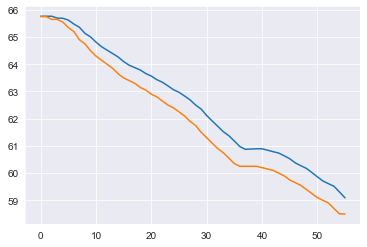

In [26]:
plt.plot(test_results2['Test Predictions2'][:])
plt.plot(test_results2['Actuals2'][:])

In [27]:
from sklearn.metrics import mean_squared_error as mse
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

2/2 [==============================] - 0s 14ms/step


(    Predictions  Actuals
 0     65.764786    65.75
 1     65.764832    65.75
 2     65.764839    65.65
 3     65.697166    65.65
 4     65.690681    65.55
 5     65.623421    65.35
 6     65.478012    65.20
 7     65.359962    64.90
 8     65.136055    64.75
 9     65.006851    64.50
 10    64.813721    64.30
 11    64.645325    64.15
 12    64.519310    64.00
 13    64.394653    63.85
 14    64.267464    63.65
 15    64.098183    63.50
 16    63.964035    63.40
 17    63.875725    63.30
 18    63.789272    63.15
 19    63.658192    63.05
 20    63.564831    62.90
 21    63.433445    62.80
 22    63.338734    62.65
 23    63.205376    62.50
 24    63.064808    62.40
 25    62.970242    62.25
 26    62.833973    62.10
 27    62.690212    61.90
 28    62.501385    61.75
 29    62.353718    61.50
 30    62.116840    61.30
 31    61.914581    61.10
 32    61.721066    60.90
 33    61.523228    60.75
 34    61.373997    60.55
 35    61.178020    60.35
 36    60.973232    60.25
 37    60.87

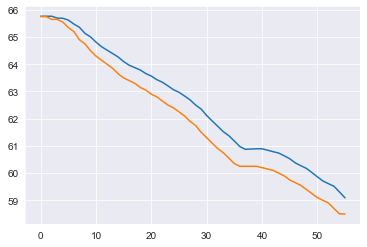

In [28]:
plot_predictions1(model1, X_test2, y_test2)

In [30]:
acc = model1.evaluate(X_test2, y_test2)

print(f'Accuracy of model is {acc}')

2/2 [==============================] - 1s 5ms/step - loss: 0.4216 - root_mean_squared_error: 0.6493
Accuracy of model is [0.4216369092464447, 0.6493357419967651]


In [32]:
test_results2

,Test Predictions2,Actuals2
0,65.764786,65.75
1,65.764832,65.75
2,65.764839,65.65
3,65.697166,65.65
4,65.690681,65.55
5,65.623421,65.35
6,65.478012,65.20
7,65.359962,64.90
8,65.136055,64.75
9,65.006851,64.50


In [38]:
#If predicted value is greater than 65 then motor is rejected

print("******************************************************")
if ((test_results2["Test Predictions2"]>65).any()):
    print("Keep Motor running, predicted value is greater than 65 degrees!!!")
else:
    print("Motor Validation Passed!!!")
print("******************************************************")

******************************************************
Keep Motor running, predicted value is greater than 65 degrees!!!
******************************************************
